# Exempel på:   
- Bollinger features samt plot  
- nya bättre predctors (features)  
- backtesting  

In [189]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


## Get the ticker

In [190]:
df = pd.DataFrame()
ticker = "BTC-USD"
# ticker = "TSLA-USD"

# if os.path.exists(ticker+".csv"):
#     print('använd sparad fil')
#     df = pd.read_csv(ticker+".csv", index_col=0)
# else:
df = yf.download(ticker,period='max')  #  tex: start="2019-01-01", end="2020-01-01")
df.to_csv(ticker+".csv")

df.index = pd.to_datetime(df.index)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100
...,...,...,...,...,...,...
2022-09-22,18534.6504,19456.9102,18415.5918,19413.5508,19413.5508,41135767926
2022-09-23,19412.4004,19464.6719,18617.5527,19297.6387,19297.6387,38896078052
2022-09-24,19296.9902,19310.1973,18861.9746,18937.0117,18937.0117,26149643168


<AxesSubplot:xlabel='Date'>

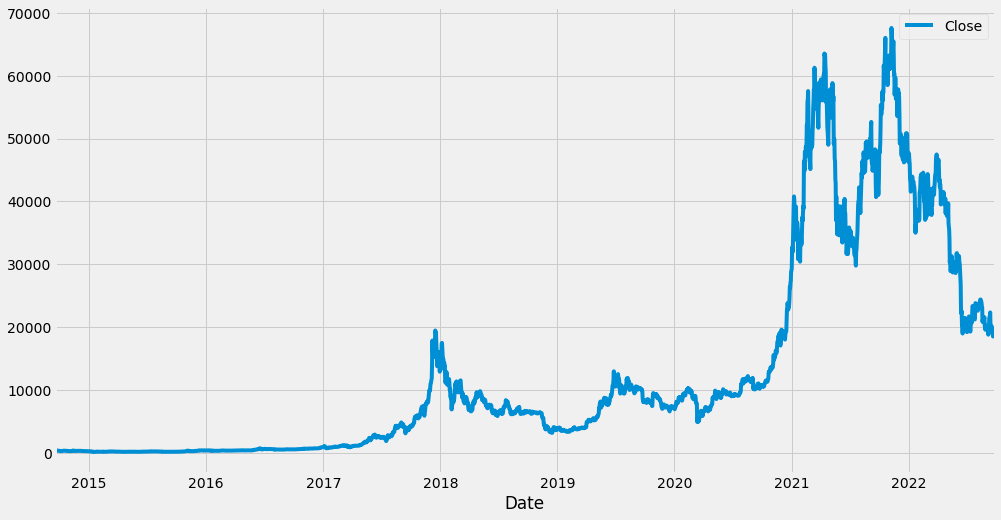

In [191]:
# bigger size
plt.rcParams['figure.figsize'] = [15, 8]
df.plot.line(y="Close") #, use_index=True)

## Compute Bollinger bands

In [192]:
from ta.volatility import BollingerBands
    
def add_bolinger_bands(df):
    # df.dropna(inplace=True)

    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)

    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Bollinger Band high indicator
    df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

    df['Sell'] = ((df['Close'] > df['bb_bbh']) & (df['stoch_k'] > 0.95))*1
    df['Buy'] = ((df['Close'] < df['bb_bbl']) & (df['stoch_k'] < 0.05))*1

    df.dropna(inplace=True)


## Set predictors and target 

In [193]:
def indicators(df, bollinger=True):
    df['SMA_180'] = ta.trend.sma_indicator(df['Close'], window=180)
    df['stoch_k'] = ta.momentum.stochrsi_k(df['Close'], window=10)
 
    # Target    
    df['Tomorrow'] = df['Close'].shift(-1)   # to tomorrow's close price - alltså nästa dag
    df['After_tomorrow'] = df['Close'].shift(-2)   # to after tomorrow's close price - alltså om två dagar
    df['y'] = (df['Tomorrow'] > df['Close']).astype(int)
    df.dropna(inplace=True)
    predictors = ['Open','High', 'Low', 'Close', 'Volume', 'SMA_180', 'stoch_k'] # columns to use as features
    if bollinger:
        add_bolinger_bands(df)
        predictors += ['bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli', 'Sell', 'Buy'] # lägg till bollinge kolumner
    return predictors
        

In [194]:
predictors=indicators(df, bollinger = True)

df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,SMA_180,stoch_k,Tomorrow,After_tomorrow,y,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,Sell,Buy
Date,,,,,,,,,,,,,,,,,,
2022-09-22,18534.6504,19456.9102,18415.5918,19413.5508,19413.5508,41135767926,27738.2664,0.2920,19297.6387,18937.0117,0,20012.2469,22031.0574,17993.4363,0.0,0.0,0,0
2022-09-23,19412.4004,19464.6719,18617.5527,19297.6387,19297.6387,38896078052,27585.3617,0.5556,18937.0117,18802.0977,0,19985.5244,22027.1858,17943.8630,0.0,0.0,0,0
2022-09-24,19296.9902,19310.1973,18861.9746,18937.0117,18937.0117,26149643168,27428.7451,0.7312,18802.0977,19172.3418,0,19933.0394,22025.2243,17840.8544,0.0,0.0,0,0


## Plot exempel (med fejkad predict)

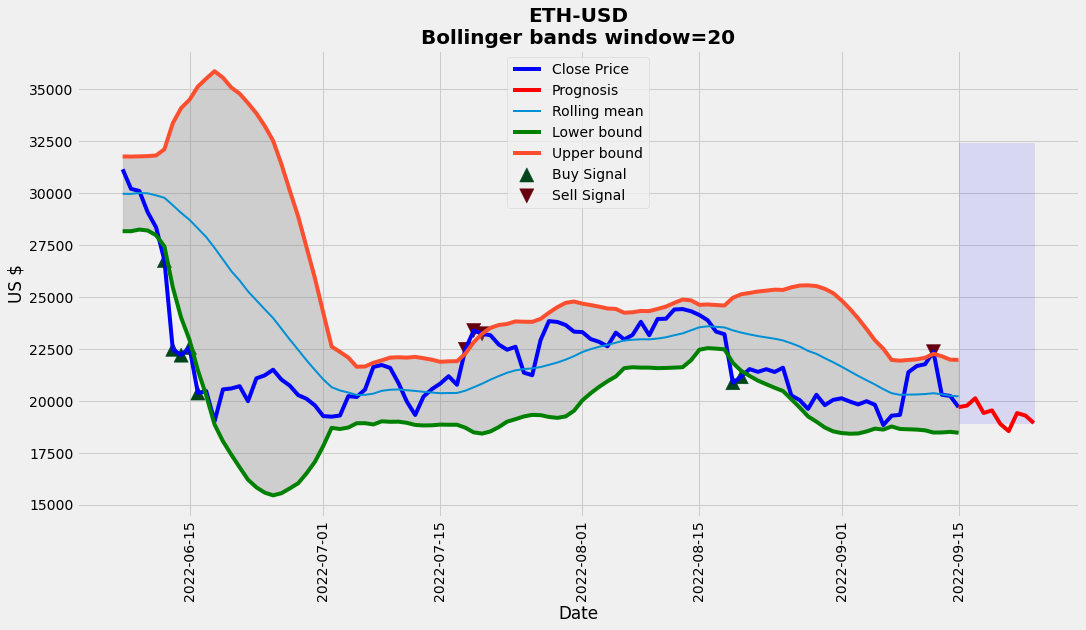

In [195]:
# Plot exempel matplotlib

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

###############################################
### jag fejkar här att det finns en prognos ###
###############################################
antal_ticks = 100 # number of ticks to plot
antal_prognos = 10 # number of ticks predicted
df_prognos = df[-antal_prognos:] # get fejkade prognos ticks
# get the last antal_ticks before that (the real ticks)
df_ticks = df[-(antal_ticks+antal_prognos):-antal_prognos+1]
########### fejk end ###########################

### define plot area width=16 height=8 ###
fig, ax = plt.subplots(figsize=(16,8))

### create the plot to be modified ###
ax.plot(df_ticks['Close'], label='Close Price', linewidth=4, color='blue')    
ax.plot(df_prognos['Close'], label='Prognosis', linewidth=4, color='red') 

#### now modify the plot before showing it

### sätta egna ticks möjligt men inte nödvändigt då plt sköter det bättre själv ###
# ticks = df.index.values[::90]     
# tick_labels=[tick.year for tick in ticks]
# plt.xticks(ticks, rotation=90)
# ax.set_xticklabels(tick_labels)

ax.plot(df_ticks['bb_bbm'], label='Rolling mean', linewidth=2)   # plot another line in the same fig
ax.plot(df_ticks['bb_bbl'], label='Lower bound', linewidth=4, color='g')   # plot another line in the same fig
# plot another line in the same fig
ax.plot(df_ticks['bb_bbh'], label='Upper bound', linewidth=4)

### add buy /sell signals ###
df_Buy  = df_ticks.query('Close < bb_bbl')
df_Sell = df_ticks.query('Close > bb_bbh')
ax.scatter(df_Buy.index, df_Buy['Close'], s = 200, c=df_Buy['bb_bbli'], cmap='Greens_r', 
            label='Buy Signal', marker='^', alpha=1)
ax.scatter(df_Sell.index, df_Sell['Close'], s= 200, c=df_Sell['bb_bbhi'], cmap='Reds_r',
            label='Sell Signal', marker='v', alpha=1)

plt.xticks(rotation=90)

### super title ###
# plt.suptitle('ETH-USD Bollinger bands',fontsize=20, fontweight='bold')

### title ###
plt.title('ETH-USD\nBollinger bands window=20',fontsize=20,fontweight='bold')

### grey bollinger area between bands ###
ax.fill_between(df_ticks.index, df_ticks['bb_bbl'], df_ticks['bb_bbh'], color='grey', alpha=0.3)

### highlight the prognosis are ###
#ax.fill_between(df_prognos.index, df_prognos['bb_bbl'], df_prognos['bb_bbh'], color='blue', alpha=0.3)
ax.axvspan(xmin=df_prognos.index[0], xmax=df_prognos.index[-1], ymin=0.2, ymax=0.8,color='blue', alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("US $")
ax.legend()   # parametrar tex. (loc='upper left', fontsize=16)
plt.show()

## Start with ML

In [196]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [197]:
display(df.y.value_counts())


1    1473
0    1259
Name: y, dtype: int64

In [198]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=2022)

train = df.iloc[:-100]
test = df.iloc[-100:]

rf.fit(train[predictors], train["y"])


RandomForestClassifier(min_samples_split=10, random_state=2022)

### En full omgång fit + predict
Returnerar en df med kolumnerna true_y och pred_y

<AxesSubplot:title={'center':'Predictions vs true values (y)'}, xlabel='Date'>

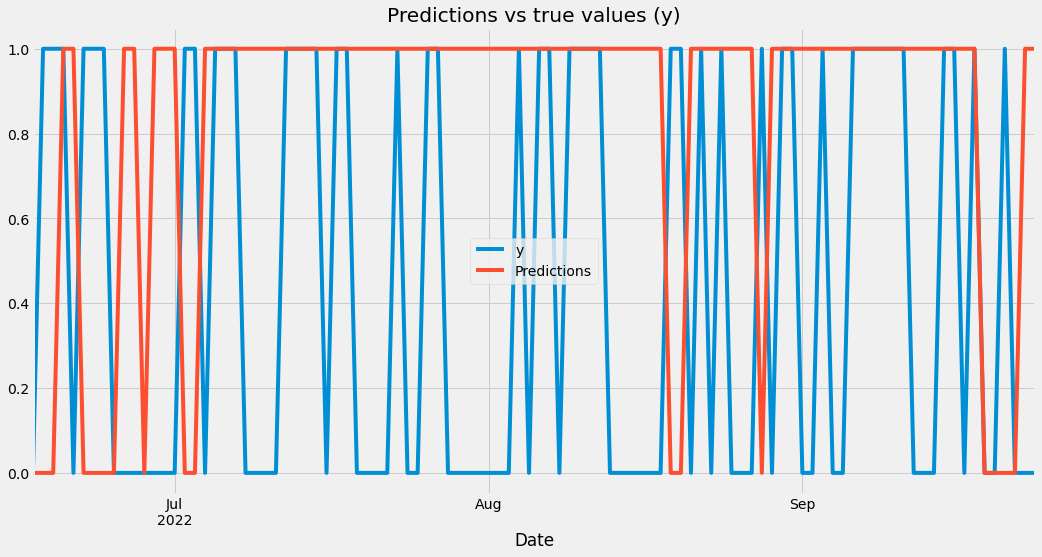

In [199]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])
    
    if proba_val: # använd proba
        preds = model.predict_proba(test[predictors])[:,1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])
        
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    
    return combined

combined1=fit_predict(train, test, 'y', predictors, rf, proba_val=0.6)
combined1.plot( figsize=(16, 8), title=f"Predictions vs true values (y)")
# combined2=fit_predict(train, test, 'y2', predictors, rf2, proba_val=0.6)
# combined2.plot( figsize=(16, 8), title="Predictions vs true values (y2)")
    


### En backtest för tidsserier

In [200]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])
    
    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec




In [201]:
# # cross validation funkar inte bra med timeseries
# scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='precision')
# scores.mean()

predictions1 = backtest(df, 'y', rf, predictors, proba_val=0.6, step=180)
first_try1=print_results(predictions1,'y')

# predictions2 = backtest(df, 'y2', rf2, predictors, proba_val=0.6, step=180)
# first_try2=print_results(predictions2, 'y2')


Fördelning av y: 1 vs 0:
1    0.5417
0    0.4583
Name: y, dtype: float64
y  Predictions
1  0              1034
0  0               860
1  1               251
0  1               227
dtype: int64
Precision:	0.5251


### Beräkna nya (bättre) predictors
använder bara close för beräkningar

In [202]:
def new_features(df, target):
    # tidsintervall i dagar för rullande medelvärden
    horizons = [2, 5, 60, 250]  # skulle helst ha med upp till 4 år men ETH har för få värden
    new_predictors = []

    for horizon in horizons:
        rolling_averages = df.rolling(horizon,1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df["Close"] / rolling_averages["Close"]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon,1).sum()[target]
        
        new_predictors += [ratio_column, trend_column]
        
    new_predictors.append('stoch_k') 
    df = df.dropna()
    return df, new_predictors

In [203]:
pd.options.display.max_columns=200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
df,new_predictors = new_features(df,'y')
df[new_predictors+['y']]

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y
Date,,,,,,,,,,
2015-04-04,0.9988,0.0,0.9988,0.0,0.9988,0.0,0.9988,0.0,0.9842,1
2015-04-05,1.0134,1.0,1.0171,1.0,1.0171,1.0,1.0171,1.0,0.9842,0
2015-04-06,0.9901,1.0,0.9979,1.0,0.9979,1.0,0.9979,1.0,0.8901,0
2015-04-07,0.9955,0.0,0.9911,1.0,0.9911,1.0,0.9911,1.0,0.7716,0
2015-04-08,0.9836,0.0,0.9662,1.0,0.9657,1.0,0.9657,1.0,0.4691,0
...,...,...,...,...,...,...,...,...,...,...
2022-09-20,0.9830,1.0,0.9662,3.0,0.8712,27.0,0.6003,121.0,0.0183,0
2022-09-21,0.9908,0.0,0.9607,2.0,0.8580,27.0,0.5912,120.0,0.0183,1
2022-09-22,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0,0.2920,0


Blir modellen bättre?

In [204]:
# backtestning med nya predictors
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

predictions1 = backtest(df, 'y', rf, new_predictors, proba_val=0.6, step=180)

second_try = print_results(predictions1, 'y')
print('First_try:\t', round(first_try1,4))

Fördelning av y: 1 vs 0:
1    0.542
0    0.458
Name: y, dtype: float64
y  Predictions
1  0              921
0  0              776
1  1              364
0  1              310
dtype: int64
Precision:	0.5401
First_try:	 0.5251


Confusion matrix (egentligen meningslös eftersom vi bara är intresserde av precision)

In [205]:
import seaborn as sns

def confusion(y_true, y_pred, labels=['Sell', 'Buy']):
    # plot the confusion matrix mha seaborn heatmap
    cm = confusion_matrix(y_true, y_pred)
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
# confusion(predictions2["y"], predictions2["Predictions"])


Gör en GridSearch på modeller och parametrar

In [206]:

# Gridsearch

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
rf = RandomForestClassifier(random_state=2022)
et = ExtraTreesClassifier(random_state=2022)
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=2022,  n_jobs=-1)
cb = CatBoostClassifier(random_state=1, silent=True, early_stopping_rounds=50, eval_metric='Precision')
ridge = RidgeClassifier(     )
tscv = TimeSeriesSplit(n_splits=5)
def grid_search(X, y, scoring='precision'):
    grid_parms = {
        'cb': {
            'model': cb,
            'params': {
                'iterations': [100, 500, 1000],
                'learning_rate': [0.01, 0.03, 0.1],
                'depth': [6, 10, 12],
                'l2_leaf_reg': [3, 5, 7],
            }

        },
        
        'xgb': {
            
            'model': xgb,
            'params': {
                    'learning_rate' : [0.005,0.01, 0.3,0.5],
                    # 'L1' : [0.1,0.5,1],
                    # 'L2' :  [0.1,0.5,1],  
                    'n_estimators' : [50, 100, 200, 500],
                    'max_depth' : [ 5, 7, 10],
                    'min_child_weight' : [3,5],
                    'gamma' : [0.5, 0.7, 0.9],
                    'subsample' : [0.4,0.6],
            }
            
        },
        
        'et': {
            'model': et,
            'params': {
                    'n_estimators': [ 200, 1000, 2000],
                    'min_samples_split': [5, 10, 20, 50]
            }
        },
        'rf': {
            'model': rf,
            'params': {
                    'n_estimators': [1000, 2000, 3000],
                    'min_samples_split': [10, 20, 50, 100]
            }
        },
        'knn': {
            'model': knn,
            'params': {
                'n_neighbors': [2,3, 5, 8]
            }
        },
        'ridge': {
            'model': ridge,
            'params': {
                    'alpha': [0.1, 0.5, 1, 10, 100]
            }
        }
    }
    scores = []
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, config in grid_parms.items():
        print(model_name, config['params'])
        
        gs = GridSearchCV(config['model'], config['params'], scoring='precision',n_jobs=-1,
                            cv=tscv, return_train_score=False, error_score='raise', verbose=3)
        gs.fit(X, y)
        scores.append({
            'model': gs.best_estimator_,
            'model_name': model_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
        df_grid = pd.DataFrame(scores, columns=['model_name', 'model', 'best_score', 'best_params']).sort_values(
                        by='best_score', ascending=False)
        
    return df_grid     

# df_grid = grid_search(df[new_predictors], df.y)

# pickle.dump(df_grid, open('df_grid.sav', 'wb'))


In [207]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 180  # default 50
        
df_grid = pickle.load(open('df_grid.sav', 'rb'))
df_grid[['model_name', 'best_score', 'best_params']]

,model_name,best_score,best_params
1,xgb,0.6825,"{'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}"
2,et,0.6514,"{'min_samples_split': 10, 'n_estimators': 1000}"
5,ridge,0.6360,{'alpha': 0.5}
0,cb,0.6266,"{'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.01}"
4,knn,0.5886,{'n_neighbors': 5}
3,rf,0.4799,"{'min_samples_split': 50, 'n_estimators': 2000}"


In [208]:
best_model = df_grid.iloc[0].model
best_params = df_grid.iloc[0].best_params
print(best_model)
display(best_params)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.7, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)


{'gamma': 0.7,
 'learning_rate': 0.005,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 0.4}

### XGBoost vann ganska stort!

In [210]:
xgb = df_grid.query('model_name == "xgb"').model.values[0]
xgb_params = df_grid.query('model_name == "xgb"').best_params.values[0]
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params, random_state=2022, n_jobs=-1)

predictions_xgb = backtest(df, 'y', xgb, new_predictors, proba_val= 0.6, step=180)

# print("xgb precision_score:\t", round(precision_score(predictions_xgb["y"], predictions_xgb["Predictions"]), 4))
xgb_try = print_results(predictions_xgb,'y')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y: 1 vs 0:
1    0.542
0    0.458
Name: y, dtype: float64
y  Predictions
1  0              1177
0  0               997
1  1               108
0  1                89
dtype: int64
Precision:	0.5482


,importance
Close_Ratio_2,0.1146
Close_Ratio_60,0.1144
Trend_2,0.1143
Close_Ratio_5,0.1139
Close_Ratio_250,0.1119
Trend_60,0.1103
stoch_k,0.1099
Trend_5,0.1066
Trend_250,0.1041


In [317]:
from datetime import timedelta
print(f'Låt {df.index.max().strftime("%Y-%m-%d")} ge prognos för {(df.index.max() + timedelta(days=1)).strftime("%Y-%m-%d")}')

proba_val=0.6
### Obs i sista raden är y okänd och alltid satt till 0, så vi vet inte ännu om vi har rätt eller fel
preds = xgb.predict_proba(df.iloc[-1:][new_predictors])[:, 1]
preds[preds >= proba_val] = 1
preds[preds < proba_val] = 0
print(preds[0].astype(int))



Låt 2022-09-24 ge prognos för 2022-09-25
0


In [318]:
df1, new_list1 = new_features(df,'y') 

In [319]:
df1[new_list1]

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k
Date,,,,,,,,,
2015-04-05,1.0134,1.0,1.0134,1.0,1.0134,1.0,1.0134,1.0,0.9842
2015-04-06,0.9901,1.0,0.9957,1.0,0.9957,1.0,0.9957,1.0,0.8901
2015-04-07,0.9955,0.0,0.9900,1.0,0.9900,1.0,0.9900,1.0,0.7716
2015-04-08,0.9836,0.0,0.9662,1.0,0.9662,1.0,0.9662,1.0,0.4691
2015-04-09,0.9972,0.0,0.9685,1.0,0.9672,1.0,0.9672,1.0,0.2388
...,...,...,...,...,...,...,...,...,...
2022-09-20,0.9830,1.0,0.9662,3.0,0.8712,27.0,0.6003,121.0,0.0183
2022-09-21,0.9908,0.0,0.9607,2.0,0.8580,27.0,0.5912,120.0,0.0183
2022-09-22,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0,0.2920


In [320]:
predictions_xgb = backtest(df, 'y', xgb, new_predictors, proba_val= 0.6, step=30)

# print("xgb precision_score:\t", round(precision_score(predictions_xgb["y"], predictions_xgb["Predictions"]), 4))
xgb_try = print_results(predictions_xgb,'y')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y: 1 vs 0:
1    0.542
0    0.458
Name: y, dtype: float64
y  Predictions
1  0              1166
0  0               988
1  1               119
0  1                98
dtype: int64
Precision:	0.5484


,importance
Close_Ratio_250,0.1173
Close_Ratio_2,0.1162
Trend_60,0.1159
Close_Ratio_60,0.1146
Close_Ratio_5,0.1135
Trend_5,0.1126
stoch_k,0.1090
Trend_250,0.1043
Trend_2,0.0966


In [323]:
predictions_xgb = backtest(df, 'y2', xgb, new_predictors, proba_val= 0.6, step=30)

# print("xgb precision_score:\t", round(precision_score(predictions_xgb["y"], predictions_xgb["Predictions"]), 4))
xgb_try = print_results(predictions_xgb,'y2')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y2: 1 vs 0:
1    0.55
0    0.45
Name: y2, dtype: float64
y2  Predictions
0   0              887
1   0              887
    1              417
0   1              180
dtype: int64
Precision:	0.6985


,importance
Trend_2,0.2880
Close_Ratio_5,0.1096
Close_Ratio_2,0.1070
Trend_5,0.0957
stoch_k,0.0852
Trend_60,0.0847
Close_Ratio_60,0.0783
Close_Ratio_250,0.0767
Trend_250,0.0749
